# Day 9: Rope Bridge

[From now on, I won't copy everything. I will just write a short summary.]

## Part 1

### Rules of the map

Model a rope, represented by its head and tail, in a 2D plane.

The head (H) and tail (T) must always be touching (diagonally adjacent and even overlapping both count as touching):

    ....
    .TH.
    ....

    ....
    .H..
    ..T.
    ....

    ...
    .H. (H covers T)
    ...

If the head is ever two steps directly up, down, left, or right from the tail, the tail must also move one step in that direction so it remains close enough:

    .....    .....    .....
    .TH.. -> .T.H. -> ..TH.
    .....    .....    .....

    ...    ...    ...
    .T.    .T.    ...
    .H. -> ... -> .T.
    ...    .H.    .H.
    ...    ...    ...

Otherwise, if the head and tail aren't touching and aren't in the same row or column, the tail always moves one step diagonally to keep up:

    .....    .....    .....
    .....    ..H..    ..H..
    ..H.. -> ..... -> ..T..
    .T...    .T...    .....
    .....    .....    .....

    .....    .....    .....
    .....    .....    .....
    ..H.. -> ...H. -> ..TH.
    .T...    .T...    .....
    .....    .....    .....

[In other words, the behaviour of the T in this case is the same as the previous case: it will move according to the H, not according to T.]

### Regarding the input

You just need to work out where the tail goes as the head follows a series of motions. Assume the head and the tail both start at the same position, overlapping.

For example:

    R 4
    U 4
    L 3
    D 1
    R 4
    D 1
    L 5
    R 2

This series of motions moves the head right four steps, then up four steps, then left three steps, then down one step, and so on. After each step, you'll need to update the position of the tail if the step means the head is no longer adjacent to the tail. Visually, these motions occur as follows (s marks the starting position as a reference point):

== Initial State ==

    ......
    ......
    ......
    ......
    H.....  (H covers T, s)

== R 4 ==

    ......
    ......
    ......
    ......
    TH....  (T covers s)

    ......
    ......
    ......
    ......
    sTH...

...

After simulating the rope, you can count up all of the positions the tail visited at least once. In this diagram, s again marks the starting position (which the tail also visited) and # marks other positions the tail visited:

    ..##..
    ...##.
    .####.
    ....#.
    s###..

So, there are 13 positions the tail visited at least once.

Simulate your complete hypothetical series of motions. How many positions does the tail of the rope visit at least once?

We'll put everything in a dataframe with the following columns:
- The movements (R, U, L, D) (each one representing a single movement)
- Each head position (x, y)
- Each tail position (x, y)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("sample input.txt", "r") as f:
    lines = f.read().splitlines()

movements = ["S"]
for line in lines:    
    dir, steps = line.split()
    movements.extend([dir for i in range(int(steps))])

# create dataframe with movements as column
rope_df = pd.DataFrame(movements, columns=["direction"])
rope_df.head()

,direction
0,S
1,R
2,R
3,R
4,R


In [3]:
def get_coordinates_head(directions):
    """Converts directions to coordinates of the head"""
    
    coordinates = []
    current = (0, 0)

    for dir in directions:
        if dir == "R":
            current = (current[0] + 1, current[1])
        elif dir == "L":
            current = (current[0] - 1, current[1])
        elif dir == "U":
            current = (current[0], current[1] + 1)
        elif dir == "D":
            current = (current[0], current[1] - 1)
        coordinates.append(current)
    
    return coordinates

rope_df.loc[:, "coordinates_head"] = get_coordinates_head(rope_df.loc[:, "direction"])
rope_df.head()

,direction,coordinates_head
0,S,"(0, 0)"
1,R,"(1, 0)"
2,R,"(2, 0)"
3,R,"(3, 0)"
4,R,"(4, 0)"


In [4]:
def get_coordinates_tail(coordinates_head):
    """Converts coordinates of the head to coordinates of the tail"""
    
    coordinates = []
    current = (0, 0)
    for i, coord in enumerate(coordinates_head):
        # if head+1 is > 1 manhattan distance from tail, then tail moves to head

        if np.linalg.norm(np.array(coord) - np.array(current)) >= 2:
            # update tail
            current = coordinates_head[i-1]

        coordinates.append(current)
    return coordinates

# head_coors = [(0, 0), (1, 0), (1, 1), (1, 2), (1, 1)]
# print(head_coors)
# get_coordinates_tail(head_coors)
rope_df.loc[:, "coordinates_tail"] = get_coordinates_tail(rope_df.loc[:, "coordinates_head"])
rope_df.head()

,direction,coordinates_head,coordinates_tail
0,S,"(0, 0)","(0, 0)"
1,R,"(1, 0)","(0, 0)"
2,R,"(2, 0)","(1, 0)"
3,R,"(3, 0)","(2, 0)"
4,R,"(4, 0)","(3, 0)"


In [183]:
# How many positions does the tail of the rope visit at least once?
f'Answer: {len(set(rope_df.loc[:, "coordinates_tail"]))}'

'Answer: 13'

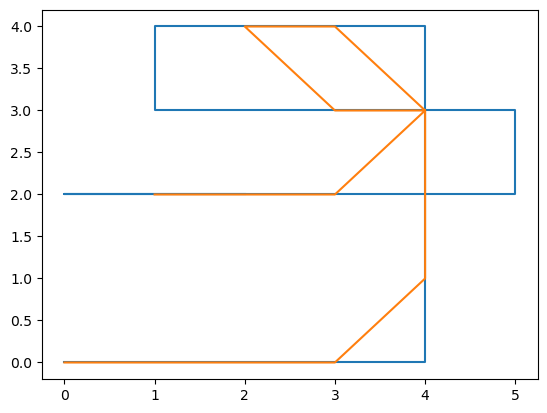

In [184]:
# plot coordinates of the head and tail

plt.plot(rope_df["coordinates_head"].apply(lambda x: x[0]), rope_df["coordinates_head"].apply(lambda x: x[1]), label="head")
plt.plot(rope_df["coordinates_tail"].apply(lambda x: x[0]), rope_df["coordinates_tail"].apply(lambda x: x[1]), label="tail")

## Part 2

Now instead of 1 tail, the rope is 10 knots long; H, 1, ... 9.

Also, the way the position of the knots are updated must be different. Instead of moving to the previous position of the head (or the previous knot), they move in the direction it went. Although my approach had identical results, it won't work for more knots.

Example of going up:

    ......
    ......
    ......
    ....H.
    4321..  (4 covers 5, 6, 7, 8, 9, s)

    ......
    ......
    ....H.
    .4321.
    5.....  (5 covers 6, 7, 8, 9, s)

Also note that each knot has a minimum distance to the head.

I will use this new approach and, as I said before, it should yield the same results. Then I can generalize it to any number of knots.
For this I will use the list of directions instead of the coordinates of head.

In [20]:
with open("input.txt", "r") as f:
    lines = f.read().splitlines()

movements = ["S"]
for line in lines:    
    dir, steps = line.split()
    movements.extend([dir for i in range(int(steps))])

# create dataframe with movements as column
rope_df = pd.DataFrame(movements, columns=["direction"])

rope_df.loc[:, 0] = get_coordinates_head(rope_df.loc[:, "direction"])
rope_df.drop(columns=["direction"], inplace=True)
rope_df.head()

,0
0,"(0, 0)"
1,"(0, 1)"
2,"(0, 2)"
3,"(0, 1)"
4,"(0, 0)"


In [21]:
def get_coordinates_tail(coordinates_head):
    """Converts coordinates of the head to coordinates of the tail"""

    len_head = len(coordinates_head)
    coordinates = []

    current = (0, 0)
    for i, head in enumerate(coordinates_head):
        difference = np.sign(np.array(head) - np.array(current))

        if np.linalg.norm(np.array(head) - np.array(current)) >= 2:
            # update tail
            current = tuple(np.array(current) + difference)
            
        coordinates.append(current)

    return pd.Series(coordinates)

total_knots = 10
for i in range(1, total_knots):
    rope_df.loc[:, i] = get_coordinates_tail(rope_df.loc[:, i-1])
rope_df[5:9]

In [23]:
# How many positions does the tail of the rope visit at least once?
f"Answer: {len(set(rope_df.loc[:, total_knots-1]))}"


'Answer: 2455'